https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap

https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

https://link.springer.com/article/10.1007/s13748-016-0094-0

https://stackoverflow.com/questions/62663370/using-pipeline-with-gridsearchcv
https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e

https://medium.com/analytics-vidhya/a-random-forest-classifier-with-imbalanced-data-7ef4d9ebedb8

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from data_preparation import prepareData

## Import et transformations des données

Le jeu de données par défaut ne contient aucun feature engineering, il remonte les infos des tables inférieure en prenant la moyenne ou le mode selon le type de variable. L'autre jeu contient en plus le feature engineering issus de l'étape 1

In [ ]:
dfAppplication = prepareData('train', only_default=False)

## Mise de côté d'un jeu de données de validation

In [6]:
print("Distribution de la TARGET après création du jeu de validation")
counter = Counter(dfApplication.TARGET)
for k,v in counter.items():
    per = v / len(dfApplication.TARGET) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Distribution de la TARGET après création du jeu de validation
Class=1, Count=23621, Percentage=8.161%
Class=0, Count=265823, Percentage=91.839%


In [7]:
print("Distribution de la TARGET avant création du jeu de validation")
counter = Counter(dfApplication.TARGET)
for k,v in counter.items():
    per = v / len(dfApplication.TARGET) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Distribution de la TARGET avant création du jeu de validation
Class=1, Count=23621, Percentage=8.161%
Class=0, Count=265823, Percentage=91.839%


In [8]:
dfApplication, dfApplicationVal = train_test_split(dfApplication, test_size=0.3, random_state=1)

## Sauvegarde du jeu d'entrainement (par défaut et complet) et de validation  pour les étapes de sélection et d'optimisation du modèle

In [9]:
dump(dfApplication, open('dfApplicationTrain.pkl','wb'))   
dump(dfApplicationVal, open('dfApplicationVal.pkl','wb')) 
dump(dfApplicationDefault, open('dfApplicationDefault.pkl','wb')) 

In [90]:
dfApplication = load(open('dfApplicationTrain.pkl','rb'))
dfApplicationDefault = load(open('dfApplicationDefault.pkl','rb'))

## Création d'un dataframe réduit en lignes et en colonnes pour l'étape de sélection du modèle

### Optimisation de n_estimators sur RF et XGB pour la sélection des meilleurs variables

#### Optimisation de n_estimators

In [ ]:
results_n_estimators = []

if True:
    lst = [10, 25, 50, 100, 150, 200, 350, 500, 800]
    for n_estimators in lst:
        print(n_estimators)
        res = evaluateRocPrCurves(dfApplication, 
                                target='TARGET', 
                                identifier='SK_ID_CURR', 
                                model=RandomForestClassifier(n_estimators=n_estimators, max_depth=5, n_jobs=-1),
                                display_plot=False,
                                title_plot = 'Random forest | Initial | n_estimators = ' + str(n_estimators),
                                #random_state=42,
                                cv=3)
        results_n_estimators.append(res)

if True:
    lst = list((np.arange(10)+1)*2)
    lst.extend([25, 30, 35, 50])
    for n_estimators in lst:
        print(n_estimators)
        res = evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    model=XGBClassifier(n_estimators=n_estimators, max_depth=5),
                                    display_plot=False,
                                    title_plot = 'XGBoost | Initial | n_estimators = ' + str(n_estimators),
                                    #random_state=42,
                                    cv=3)
        results_n_estimators.append(res)

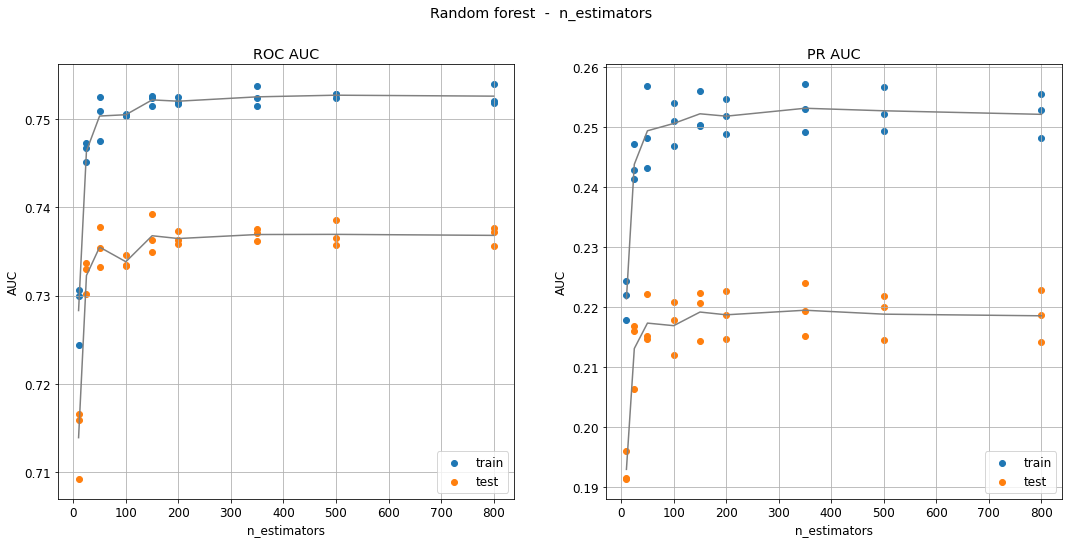

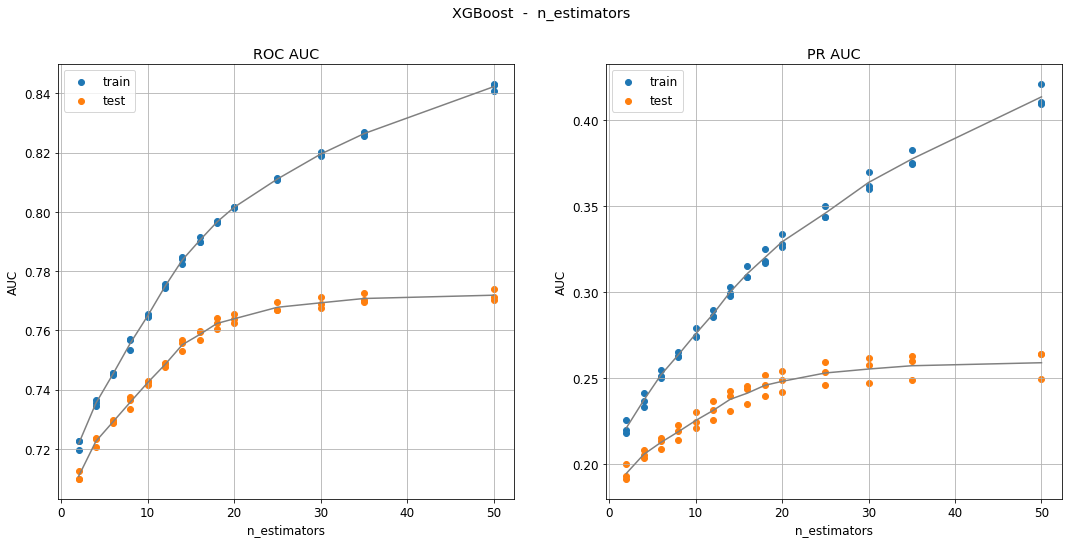

In [92]:
dfMetrics = pd.concat(results_n_estimators)
dfMetrics = dfMetrics.rename(columns={'pr_train_auc': 'pr_auc_train'})
dfMetrics['model'] = dfMetrics.apply(lambda x: x.title.split('|')[0], axis=1)
dfMetrics['parameter'] = dfMetrics.apply(lambda x: x.title.split('|')[-1].split('=')[0], axis=1)
dfMetrics['value'] = dfMetrics.apply(lambda x: float(x.title.split('|')[-1].split('=')[1]), axis=1)

dfModelParam = dfMetrics[['model','parameter']].drop_duplicates()

for index, row in dfModelParam.iterrows():
    
    m = dfMetrics[(dfMetrics.model == row.model) & (dfMetrics.parameter == row.parameter)]
    m_means = m.groupby('value').agg({'roc_auc_train':'mean','pr_auc_train':'mean','roc_auc_test':'mean','pr_auc_test':'mean'}).reset_index(drop=False)
    
    size = 1
    nbPlot = 2
    fig = plt.figure(figsize=(size * (18 * nbPlot/2), size * 8))

    sub = fig.add_subplot(1,nbPlot,1)
    plt.xlabel(row.parameter)
    plt.ylabel('AUC')
    plt.title('ROC AUC')
    #plt.axis('tight')
    plt.grid(True)
    plt.scatter(m.value.values, m.roc_auc_train.values, alpha=1, label = 'train')
    plt.plot(m_means.value, m_means.roc_auc_train, color='grey')
    plt.scatter(m.value.values, m.roc_auc_test.values, alpha=1, label = 'test')
    plt.plot(m_means.value, m_means.roc_auc_test, color='grey')
    plt.legend()
    plt.rcParams.update({'font.size':12, 'font.style':'normal'})
    plt.suptitle('ROC AUC')

    sub = fig.add_subplot(1,nbPlot,2)
    plt.xlabel(row.parameter)
    plt.ylabel('AUC')
    plt.title('PR AUC')
    #plt.axis('tight')
    plt.grid(True)
    plt.scatter(m.value.values, m.pr_auc_train.values, alpha=1, label = 'train')
    plt.plot(m_means.value, m_means.pr_auc_train, color='grey')
    plt.scatter(m.value.values, m.pr_auc_test.values, alpha=1, label = 'test')
    plt.plot(m_means.value, m_means.pr_auc_test, color='grey')
    plt.legend()
    plt.rcParams.update({'font.size':12, 'font.style':'normal'})
    plt.suptitle('PR AUC')

    plt.rcParams.update({'font.size':12, 'font.style':'normal'})
    plt.suptitle("{} - {}".format(row.model, row.parameter))

    plt.show()


In [96]:
RFmodel = model=RandomForestClassifier(n_estimators=150, max_depth=5, n_jobs=-1)
XGmodel = XGBClassifier(n_estimators=30, max_depth=5)

#### Sélection de variables

In [103]:
def imputeScaleAndEncode(df1, 
                    target='', 
                    identifier=''):
    
    df = df1.copy()
    
    if type(target) == str:
        target = [target]
    if type(identifier) == str:
        identifier = [identifier]
    
    colToExclude = target
    colToExclude.extend(identifier)
    
    for col in df.columns:
        if col not in colToExclude:
            if df[col].dtypes == 'object':
                df[col] = df[col].replace(np.nan, 'missing')
                df[col] = OrdinalEncoder().fit_transform(df[[col]])
            elif df[col].dtype in ['int64','float64']:
                df[col] = SimpleImputer(strategy='mean').fit_transform(df[[col]])
                df[col] = MinMaxScaler().fit_transform(df[[col]])  
                
    return df

In [104]:
dfApplication = imputeScaleAndEncode(dfApplication, target='TARGET', identifier='SK_ID_CURR')
impRF = featureImportance(dfApplication, target='TARGET', identifier='SK_ID_CURR', model=RFmodel)
impXG = featureImportance(dfApplication, target='TARGET', identifier='SK_ID_CURR', model=XGmodel)

impRF = impRF[['feature','impMedian','feat_imp_classement']].rename(columns={'impMedian':'RFFeatImp','feat_imp_classement':'RFClassement'})
impXG = impXG[['feature','impMedian','feat_imp_classement']].rename(columns={'impMedian':'XGFeatImp','feat_imp_classement':'XGClassement'})

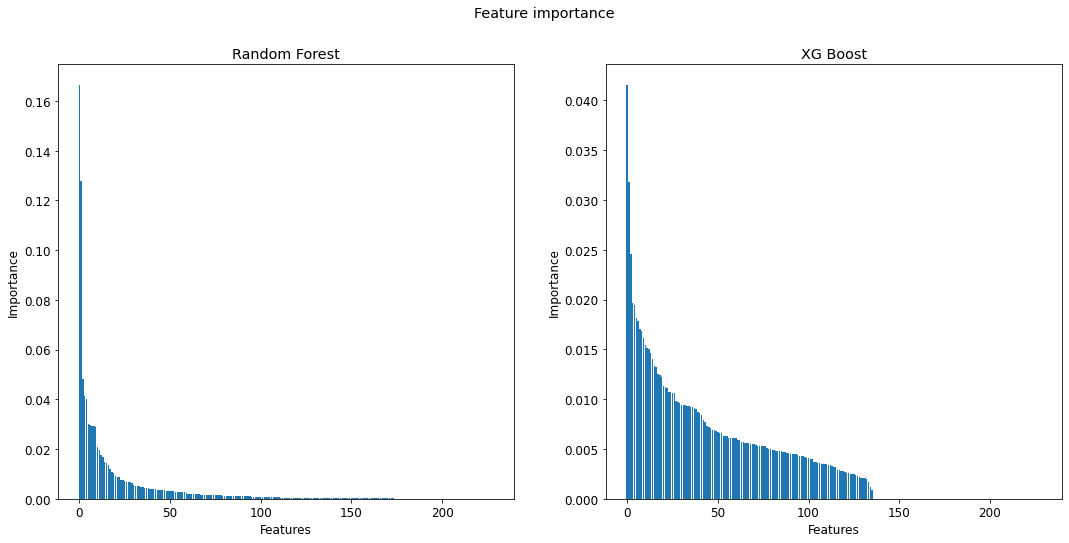

In [110]:
imp = impRF.merge(impXG, left_on='feature', right_on='feature')

imp['bestClassement'] = imp.apply(lambda x: np.min([x.RFClassement, x.XGClassement]), axis=1)
imp['diffClassement'] = imp.apply(lambda x: np.abs(x.RFClassement - x.XGClassement), axis=1)

imp = imp[['feature','RFFeatImp','XGFeatImp','RFClassement','XGClassement','bestClassement','diffClassement']]
imp = imp.sort_values('bestClassement')
imp = imp.reset_index(drop=True)

size = 1
nbPlot = 2
fig = plt.figure(figsize=(size * (18 * nbPlot/2), size * 8))

sub = fig.add_subplot(1,nbPlot,1)
sub.set_title('Random Forest')
plt.bar([x for x in range(len(imp))], imp['RFFeatImp'].sort_values(ascending=False))
plt.axis('tight')
plt.xlabel('Features')
plt.ylabel('Importance')

sub = fig.add_subplot(1,nbPlot,2)
sub.set_title('XG Boost')
plt.bar([x for x in range(len(imp))], imp['XGFeatImp'].sort_values(ascending=False))
plt.axis('tight')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.rcParams.update({'font.size':12, 'font.style':'normal'})
plt.suptitle("Feature importance")


plt.show()

In [111]:
imp

,feature,RFFeatImp,XGFeatImp,RFClassement,XGClassement,bestClassement,diffClassement
0,EXT_SOURCE_2,0.166570,0.031788,1,2,1,1
1,EXT_SOURCE_3,0.127920,0.041568,2,1,1,1
2,EXT_SOURCE_1,0.048002,0.011367,3,21,3,18
3,NAME_EDUCATION_TYPE,0.012000,0.024595,18,3,3,15
4,BURO_DAYS_CREDIT,0.041417,0.013244,4,17,4,13
5,NAME_INCOME_TYPE,0.010617,0.019656,19,4,4,15
6,INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS,0.040276,0.009818,5,28,5,23
7,AMT_GOODS_PRICE,0.005713,0.019430,31,5,5,26
8,INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG,0.030035,0.009707,6,29,6,23
9,PREV_NAME_CONTRACT_STATUS,0.029156,0.018170,9,6,6,3


#### Suppression des variables non sélectionnées

In [112]:
for index, row in imp.iterrows():
    if (row.RFClassement > 50) & (row.XGFeatImp < 0.02):
        print(row.feature)
        del dfApplication[row.feature]

FLAG_OWN_CAR
NB_DOC_FURNISHED
OWN_CAR_AGE
BASEMENTAREA_AVG
PREV_AMT_GOODS_PRICE
PREV_AMT_ANNUITY_ACTIVE
DEF_60_CNT_SOCIAL_CIRCLE
FLAG_DOCUMENT_3
AMT_CREDIT
PREV_AMT_CREDIT_ACTIVE
NAME_FAMILY_STATUS
PREV_AMT_COMPLETED
AMT_ANNUITY
BURO_AMT_CREDIT_SUM_DEBT
DEF_30_CNT_SOCIAL_CIRCLE
POSCASH_CNT_INSTALMENT_FUTURE_LEFT
PREV_NAME_CASH_LOAN_PURPOSE
PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC
POSCASH_CNT_INSTALMENT_FUTURE_DONE
ORGANIZATION_TYPE
POSCASH_SK_DPD
BURO_AMT_CREDIT_SUM
FLAG_WORK_PHONE
PREV_AMT_ANNUITY
NAME_CONTRACT_TYPE
CREDCARD_AMT_INST_MIN_REGULARITY
CREDCARD_AMT_DRAWINGS_POS_CURRENT
CREDCARD_AMT_PAYMENT_TOTAL_CURRENT
LIVINGAREA_AVG
BURO_AMT_CREDIT_MAX_OVERDUE
POSCASH_MONTHS_BALANCE
REG_CITY_NOT_LIVE_CITY
PREV_DAYS_LAST_DUE_1ST_VERSION
POSCASH_CNT_INSTALMENT
OCCUPATION_TYPE
BUROBAL_SK_DPD
PREV_AMT_APPLICATION
PREV_DAYS_FIRST_DRAWING
WALLSMATERIAL_MODE
NONLIVINGAPARTMENTS_MODE
REGION_POPULATION_RELATIVE
PREV_DAYS_TERMINATION
FONDKAPREMONT_MODE
INSTALPAYMT_AMT_INSTALMENT
PREV_NAME_TYPE_SUI

In [113]:
dfApplication.shape

(202610, 52)

#### Sauvegarde d'un dataframe réduit en lignes et en colonnes pour la sélection du modèle

In [116]:
dfApplication = shuffleDf(dfApplication).reset_index(drop=True)[0:100000]
dump(dfApplication, open('dfApplicationLight.pkl','wb'))   